# Regressor Algorithms 

- Decision Tree Regressor
- Random Forest Regressor 
- Neural Network Regessor

In [7]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score,roc_curve, classification_report
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn import tree 

from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)

def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def layer2(new_df, target, num_feats):
    x = new_df.drop([target], axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def nulldata_check(data, ascending=False):
    count = data.isnull().sum().sort_values(ascending=ascending).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=ascending)/data.iloc[:,-1].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

def featureselection_corrcorr(data, target, threshold, num_feat):
    layer1_df = layer1(data, target, threshold)
    last_features = layer2(layer1_df, target, num_feat)
    reduced_df = data[last_features]
    reduced_df[target] = data[target]
    return reduced_df

def featureselection_pca(data_minmax, target, threshold):
    x = data_minmax.drop([target], axis=1)
    y = data_minmax[target]
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = x.index)
    X_pcad[target] = y
    return X_pcad

In [23]:
def normalization_minmax(dataframe, target):
    x = dataframe
    y = dataframe[target]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x)
    array = scaler.transform(x)
    data_minmax = pd.DataFrame(array, columns=dataframe.columns)
    data_minmax[target] = y
    return data_minmax

def featureselection_randomforest(xtrain,ytrain, params, top_feat, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    #y_pred = model_tuned.predict(xtest)
    
    importance = pd.DataFrame({"importance": model.feature_importances_*100}, index = xtrain.columns)
    rf_columns = importance.sort_values(by="importance", axis=0, ascending=False).head(top_feat).index
    new_df = xtrain[rf_columns]
    new_df["50_target"] = ytrain
    return new_df

def evaluation_metrics(ytest, y_pred):
    print("MSE : ",mean_squared_error(ytest, y_pred))
    print("RMSE: ",np.sqrt(mean_squared_error(ytest, y_pred)))
    print("MAE : ",mean_absolute_error(ytest, y_pred))

### **Data Importing**

In [10]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


## 1. **Data Statistics**

In [11]:
data.shape

(6167, 136)

### **1.1. Describe Dataset**

In [12]:
describe(data)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **1.2. Categoric and Numeric variables Analysis**

In [13]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

In [14]:
sortDifferentCategory(data)

[['ind_109', 2],
 ['ind_40', 6],
 ['ind_82', 6],
 ['ind_217', 6],
 ['ind_28', 7],
 ['ind_349', 7],
 ['ind_8', 15],
 ['ind_9', 15],
 ['ind_351', 17],
 ['ind_352', 17],
 ['ind_70', 18],
 ['ind_67', 22],
 ['ind_344', 22],
 ['ind_83', 25],
 ['ind_10', 29],
 ['ind_77', 37],
 ['ind_61', 38],
 ['ind_74', 42],
 ['ind_71', 46],
 ['ind_58', 50],
 ['ind_122', 52],
 ['ind_65', 55],
 ['ind_62', 64],
 ['ind_347', 69],
 ['ind_42', 71],
 ['ind_334', 71],
 ['ind_19', 83],
 ['ind_21', 84],
 ['ind_52', 90],
 ['ind_136', 91],
 ['ind_134', 93],
 ['ind_43', 94],
 ['ind_56', 102],
 ['ind_407', 103],
 ['ind_345', 108],
 ['ind_44', 109],
 ['ind_45', 126],
 ['ind_124', 128],
 ['ind_53', 131],
 ['ind_116', 131],
 ['ind_46', 135],
 ['ind_418', 139],
 ['ind_20', 141],
 ['ind_410', 143],
 ['ind_234', 157],
 ['ind_47', 159],
 ['ind_5', 162],
 ['ind_6', 162],
 ['ind_48', 175],
 ['ind_23', 177],
 ['ind_49', 189],
 ['ind_22', 192],
 ['ind_406', 200],
 ['ind_128', 201],
 ['ind_324', 241],
 ['ind_309', 249],
 ['ind_50', 

In [15]:
data.groupby("ind_40").count()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_40,,,,,,,,,,,,,,,,,,,,,
1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
2,325,325,325,325,325,325,325,325,325,325,...,325,325,325,325,325,325,325,325,325,325
3,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799,...,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799
4,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594,...,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594
5,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
6,79,79,79,79,79,79,79,79,79,79,...,79,79,79,79,79,79,79,79,79,79


In [16]:
data.groupby("ind_420").count().tail(5)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_414,ind_416,ind_418,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_420,,,,,,,,,,,,,,,,,,,,,
288,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
290,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
291,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
297,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
?,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041


### **1.3. NULL Value Checking**

In [17]:
nulldata_check(data).sort_values(by="count",ascending=False).head(7)

,count,percentage
90_target,0,0.0
ind_416,0,0.0
ind_404,0,0.0
ind_406,0,0.0
ind_407,0,0.0
ind_410,0,0.0
ind_412,0,0.0


# **2. Data Preprocessing**

### **2.1. Noise data cleaning**

In [18]:
data["ind_420"] = data["ind_420"].replace("?", np.nan)
data["ind_422"] = data["ind_422"].replace("?", np.nan)
data = data.drop(["ind_420", "ind_422"],axis=1)

### **2.2. Dummy Transformation**

In [21]:
data_dummy = dummy_df(data, ["ind_109"])
data_dummy2 = dummy_df(data, ["ind_109","ind_40"])

num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head()

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,ind_109_GREEN,ind_109_RED
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753,1,0
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198,1,0
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503,1,0


### **2.3. Normalization (Min-Max)**

In [24]:
data_norm = data_dummy.drop(["20_target", "90_target"],axis=1)
data_minmax = normalization_minmax(data_norm, "50_target")
data_minmax.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,50_target,ind_109_GREEN,ind_109_RED
0,0.724638,0.714976,1.0,0.857143,0.571429,0.828604,0.971259,0.277947,0.303537,0.265448,...,0.555085,0.007097,0.522158,0.712766,1.0,0.498547,0.787736,35.625252,1.0,0.0
1,0.748792,0.724638,1.0,0.785714,0.607143,0.854913,0.976297,0.127062,0.313808,0.279663,...,0.570000,0.002839,0.464355,0.680851,1.0,0.537088,0.773630,35.643013,1.0,0.0
2,0.777778,0.748792,1.0,0.714286,0.642857,0.866807,0.978490,0.094075,0.308102,0.281404,...,0.580332,0.009581,0.437380,0.680851,1.0,0.615169,0.776441,35.651301,1.0,0.0


# **3. Feature Selection**

### **3.1. Principal Component Analysis**

In [25]:
data_pca = featureselection_pca(data_minmax, "50_target", 0.9)
data_pca.head()

pca sonrası değişken sayısı:  19


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,50_target
0,-1.918783,0.126473,-0.295048,0.400703,-0.076268,0.371339,0.347380,-0.614152,0.282158,0.352373,-0.385728,0.818448,0.255718,-0.452354,-0.168721,0.117936,-0.221845,0.385469,-0.012100,35.625252
1,-2.043020,0.117548,-0.204928,0.347276,-0.056899,0.328800,0.365171,-0.610495,0.253421,0.346037,-0.296312,0.821816,0.245115,-0.469800,-0.207842,0.104446,-0.231889,0.383681,-0.007942,35.643013
2,-2.088737,0.072149,-0.135119,0.317724,-0.062843,0.280218,0.375154,-0.605005,0.232259,0.319001,-0.261715,0.788576,0.268427,-0.474156,-0.203423,0.089478,-0.246062,0.361119,-0.002372,35.651301
3,-2.203106,0.090405,-0.066407,0.261085,-0.005468,0.251994,0.388037,-0.587139,0.199041,0.326763,-0.170757,0.828007,0.252351,-0.480077,-0.183597,0.063912,-0.240448,0.327890,0.011579,0.000000
4,-2.528751,0.126773,0.046819,0.234280,0.029756,0.354077,0.427985,-0.621044,0.236388,0.310995,-0.077167,0.849048,0.119429,-0.508945,-0.242452,0.143253,-0.363971,0.486983,-0.044026,-35.727079


### **3.2. Correlation based Feature Selection**

In [26]:
data_corr = featureselection_corrcorr(data_minmax, "50_target",0.6, 7)
data_corr.head()

,ind_14,ind_310,ind_330,ind_26,ind_332,ind_324,ind_18,50_target
0,0.277947,0.207870,0.944473,0.786663,0.210376,0.960129,0.179402,35.625252
1,0.127062,0.208265,0.944500,0.751886,0.208693,0.960129,0.184535,35.643013
2,0.094075,0.208449,0.944513,0.718925,0.207037,0.960129,0.188641,35.651301
3,0.082468,0.208784,0.944537,0.684934,0.205407,0.960129,0.193317,0.000000
4,0.169212,0.210127,0.944631,0.632729,0.203802,0.960129,0.215100,-35.727079


### **3.3. RandomForestRegressor based Feature Selection**

In [27]:
rf_params = {"max_depth": [2,5,8,10],
             "max_features": [2,3,4,5],
             "n_estimators": [10,50,100],
             "min_samples_split": [5,10]}

x= data_minmax.drop(["50_target"], axis=1)
y = data_minmax["50_target"]
data_rf = featureselection_randomforest(x,y, rf_params, 10) 
data_rf.head()

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   46.1s finished


,ind_77,ind_37,ind_65,ind_309,ind_332,ind_234,ind_16,ind_5,ind_102,ind_318,50_target
0,0.690476,0.759518,0.683333,0.981941,0.210376,0.237741,0.265448,0.724638,0.833798,0.960004,35.625252
1,0.690476,0.768796,0.683333,0.981941,0.208693,0.237741,0.279663,0.748792,0.847906,0.960037,35.643013
2,0.690476,0.776575,0.700000,0.981941,0.207037,0.237741,0.281404,0.777778,0.848818,0.960069,35.651301
3,0.690476,0.779653,0.700000,0.981941,0.205407,0.237741,0.290978,0.811594,0.858561,0.960102,0.000000
4,0.690476,0.809680,0.716667,0.981941,0.203802,0.237741,0.338555,0.830918,0.926951,0.960134,-35.727079


# **4. Visualization**

### **4.1. Correlation HeatMap**

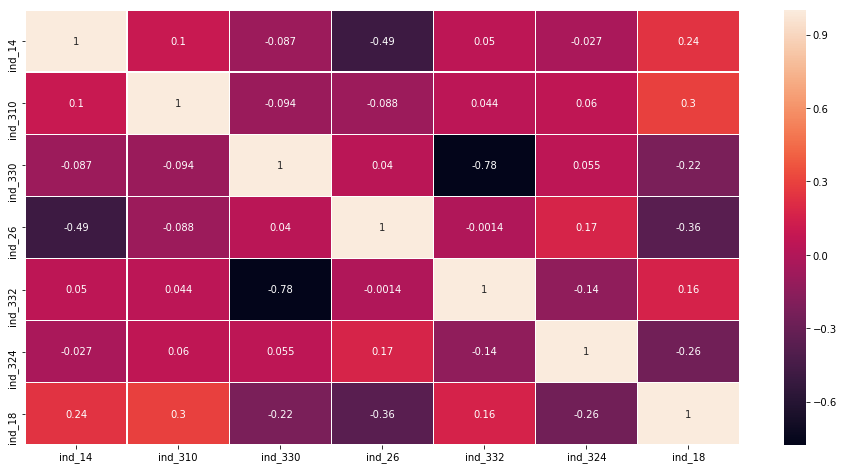

In [29]:
def heatmap(data, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(data.corr(), annot=True, linewidths=.3, ax=ax)
    plt.show()

heatmap(data_corr.drop(["50_target"], axis=1))

In [30]:
print("Most Correlated\n",correlation_df(data_corr.drop(["50_target"],axis=1)).sort_values(by="Corr", ascending=False).head(5),"\n")
print("Less Correlated\n",correlation_df(data_corr.drop(["50_target"],axis=1)).sort_values(by="Corr", ascending=True).head(5),"\n")

Most Correlated
    feature1 feature2      Corr
15  ind_330  ind_332  0.775937
3    ind_14   ind_26  0.485883
21   ind_26   ind_18  0.361721
12  ind_310   ind_18  0.296947
26  ind_324   ind_18  0.257567 

Less Correlated
    feature1 feature2      Corr
19   ind_26  ind_332  0.001387
5    ind_14  ind_324  0.027027
14  ind_330   ind_26  0.039574
10  ind_310  ind_332  0.043902
4    ind_14  ind_332  0.049891 



### **4.2. Scatter Plot**

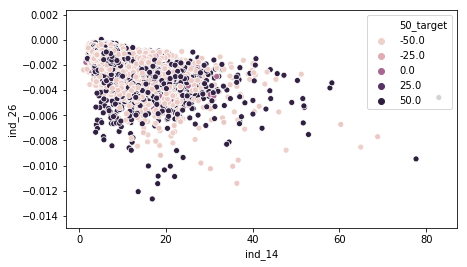

In [31]:
def scatterplot(x,y, hue, data, figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)        
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.show()
    
scatterplot("ind_14", "ind_26", "50_target", data)

### **4.3. Box Plot (Five Numbers Summary)**

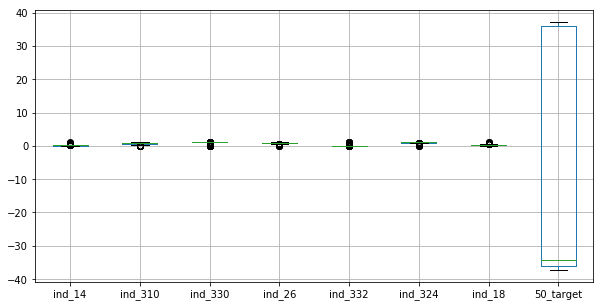

In [32]:
def boxplot(boxplot_df, figsize=(10,5)):
    plt.figure(figsize=figsize)
    boxplot_df.boxplot()
    plt.show()

boxplot(data_corr)

### **4.4. Histogram (Distribution)**

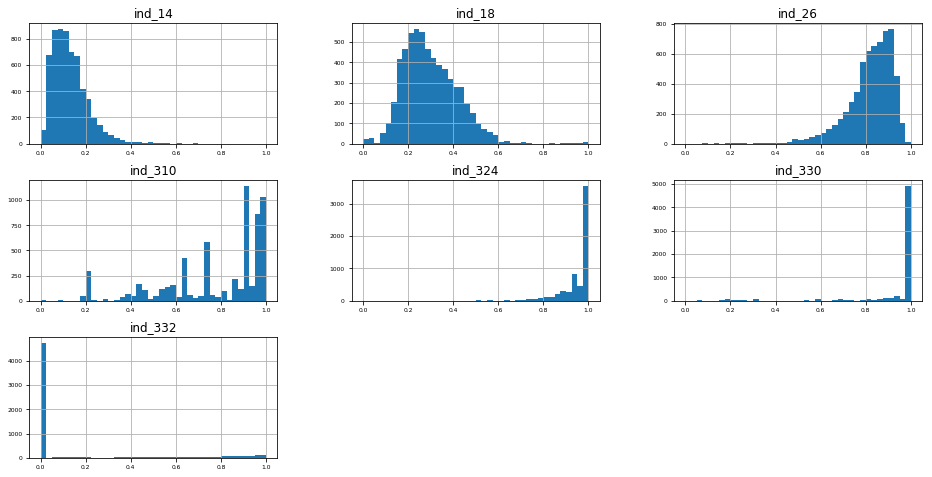

In [33]:
def histogram(datas, bins=40, xlabelsize=6, ylabelsize=6, figsize=(10,5)):
    datas.hist(figsize=figsize, bins=bins, xlabelsize=xlabelsize, ylabelsize=ylabelsize)
    plt.show()

histogram(data_corr.drop(["50_target"],axis=1), figsize=(16,8))

# **5. Modelling (Algorithms)**
- Decision Tree Regressor
- Random Forest Regressor
- Neural Network Regressor

## **5.1. DecisionTree Regressor**

### **5.1.1. PCA based FS**

In [51]:
x = data_pca.drop(["50_target"], axis=1)
y = data_pca["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeRegressor()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  1411.5333757880064
RMSE:  37.57037896785187
MAE :  21.484714314238


### **5.1.2. Correlation based FS**

In [52]:
x = data_corr.drop(["50_target"], axis=1)
y = data_corr["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeRegressor()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  745.2146441686734
RMSE:  27.298619821680976
MAE :  11.512560272273562


### **5.1.3. RandomForest based FS**

In [53]:
x = data_rf.drop(["50_target"], axis=1)
y = data_rf["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeRegressor()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  583.5861902511136
RMSE:  24.1575286453543
MAE :  8.92618859960657


### **5.1.4. Without Feature Selection**

In [54]:
x = data_minmax.drop(["50_target"], axis=1)
y = data_minmax["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

cart = DecisionTreeRegressor()
cart_model = cart.fit(xtrain, ytrain)
y_pred = cart_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  484.31344198260894
RMSE:  22.00712252845903
MAE :  7.633553942119325


## **5.2. RandomForest Regressor**

### **5.2.1. PCA based FS**

In [55]:
x = data_pca.drop(["50_target"], axis=1)
y = data_pca["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

rf = RandomForestRegressor()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  821.6482280762981
RMSE:  28.664406989789587
MAE :  24.169083356283405


### **5.2.2. Correlation based FS**

In [56]:
x = data_corr.drop(["50_target"], axis=1)
y = data_corr["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

rf = RandomForestRegressor()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  450.2105224218587
RMSE:  21.218164916454455
MAE :  14.333134853498345


### **5.2.3. RandomForest based FS**

In [57]:
x = data_rf.drop(["50_target"], axis=1)
y = data_rf["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

rf = RandomForestRegressor()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  381.93237441829444
RMSE:  19.543090196238015
MAE :  11.548472955659797


### **5.2.4. Without Feature Selection**

In [58]:
x = data_minmax.drop(["50_target"], axis=1)
y = data_minmax["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

rf = RandomForestRegressor()
rf_model = rf.fit(xtrain, ytrain)
y_pred = rf_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  261.35710650455843
RMSE:  16.16654281238133
MAE :  9.812139273274664


## **5.3. NeuralNetwork Regressor**

### **5.3.1. PCA based FS**

In [59]:
x = data_pca.drop(["50_target"], axis=1)
y = data_pca["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPRegressor()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  1034.0074523945095
RMSE:  32.15598626064064
MAE :  29.376157339991156


### **5.3.2. Correlation based FS**

In [60]:
x = data_corr.drop(["50_target"], axis=1)
y = data_corr["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPRegressor()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  1169.126704468083
RMSE:  34.19249485586103
MAE :  32.72317720721735


### **5.3.3. RandomForest based FS**

In [61]:
x = data_rf.drop(["50_target"], axis=1)
y = data_rf["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPRegressor()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  1164.0964638267278
RMSE:  34.118857891593144
MAE :  32.70033136327487


### **5.3.4. Without Feature Selection**

In [62]:
x = data_minmax.drop(["50_target"], axis=1)
y = data_minmax["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

mlp = MLPRegressor()
mlp_model = mlp.fit(xtrain, ytrain)
y_pred = mlp_model.predict(xtest)
evaluation_metrics(ytest, y_pred)

MSE :  1047.6564250223812
RMSE:  32.367521144233166
MAE :  29.61310681954652


## 5.4. Comparison Algorithms

In [64]:
models = [cart, rf, mlp]
x = data_rf.drop(["50_target"], axis=1)
y = data_rf["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)

algorithms = ["DecisionTreeRegressor", "RandomForestRegressor","NeuralNetworkRegressor"]
metrics = ["RMSE", "MSE", "MAE"]
accuracy = []

for i in models:
    model = i.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    mse = mean_squared_error(ytest, y_pred)
    mae = mean_absolute_error(ytest, y_pred)
    accuracy.append([rmse, mse, mae])

pd.DataFrame(accuracy, columns=metrics, index=algorithms)

,RMSE,MSE,MAE
DecisionTreeRegressor,24.247817,587.956641,9.069969
RandomForestRegressor,19.296309,372.347538,11.321381
NeuralNetworkRegressor,34.149322,1166.176174,32.744531


# **6. Model Tuning**

Burada ilk modelling'te en iyi sonucu veren feature selection algoritmasi kullanilarak tuning islemi gerceklestiriliyor.

In [96]:
x = data_rf.drop(["50_target"], axis=1)
y = data_rf["50_target"]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.25, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((4625, 10), (1542, 10), (4625,), (1542,))

### **6.1. DecisionTree Regressor Tuning**

In [65]:
def DecisionTreeRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = DecisionTreeRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.min_samples_split = grid_cv_model.best_params_["min_samples_split"] 
    model.min_samples_leaf = grid_cv_model.best_params_["min_samples_leaf"]
    model.max_leaf_nodes= grid_cv_model.best_params_["max_leaf_nodes"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [66]:
dt_params = {"min_samples_split": [2,3,4,5,7,10],
             "min_samples_leaf": [2,3,5,7,10,15,20],
             "max_leaf_nodes": [3,4,5,6,7,10]}

ytest, y_pred, model, best_param = DecisionTreeRegressorTuning(xtrain,ytrain, xtest, ytest, dt_params)
evaluation_metrics(ytest,y_pred)

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 734 tasks      | elapsed:    3.7s


MSE :  1069.8955545471529
RMSE:  32.70925793330006
MAE :  29.46167558295998


[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:    6.3s finished


### **6.2. RandomForest Regressor Tuning**

In [ ]:
def RandomForestRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"] 
    model.max_features = grid_cv_model.best_params_["max_features"]
    model.n_estimators= grid_cv_model.best_params_["n_estimators"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [102]:
rfr_params = {"max_depth": [2,3,5,6,7,8,9,10,12,15],
              "max_features": [2,3,4,5],
              "n_estimators": [10,20,30,50]}

ytest, y_pred, model, best_param = RandomForestRegressorTuning(xtrain,ytrain, xtest, ytest, rfr_params)
evaluation_metrics(ytest, y_pred)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1387 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  4.1min finished


MSE :  253.23538068686457
RMSE:  15.91337112892377
MAE :  10.58813441634971


### **6.3. NeuralNetwork Regressor Tuning**

In [ ]:
def NeuralNetworkRegressorTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = MLPRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"] 
    model.hidden_layer_sizes = grid_cv_model.best_params_["hidden_layer_sizes"]
    model.activation= grid_cv_model.best_params_["activation"]
    model.solver = grid_cv_model.best_params_["solver"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    return ytest, y_pred, model, grid_cv_model.best_params_

In [104]:
mlp_params = {"alpha": [0.1,0.01, 0.005],
             "hidden_layer_sizes": [(10,10), (10,10,10), (20,20), (30,20,10), (50,50)],
             "activation": ["relu", "logstics"],
              "solver": ["lbfgs", "adam","sgd"]}

ytest, y_pred, model, best_param = NeuralNetworkRegressorTuning(xtrain,ytrain, xtest, ytest, mlp_params)
evaluation_metrics(ytest, y_pred)Regressor

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 13.2min finished


MSE :  1090.565146380748
RMSE:  33.02370582446416
MAE :  30.76854313765482
